In [1]:
import pandas as pd

df = pd.read_csv('/kaggle/input/default-of-credit-card-clients-dataset/UCI_Credit_Card.csv')
df.head()


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


# Data Cleaning

In [2]:
# Drop ID column
df.drop('ID', axis=1, inplace=True)

# Check missing values
print(df.isnull().sum())

# Check duplicates
df.duplicated().sum()


LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


35

# Encoding Categorical Features


In [3]:

df.rename(columns={
    'default.payment.next.month': 'default',
    'PAY_0': 'PAY_1'
}, inplace=True)


df['SEX'] = df['SEX'].map({1: 'Male', 2: 'Female'})
df = pd.get_dummies(df, columns=['SEX', 'EDUCATION', 'MARRIAGE'], drop_first=True)


In [4]:
df.head()

,LIMIT_BAL,AGE,PAY_1,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,SEX_Male,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,False,False,True,False,False,False,False,True,False,False
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,False,False,True,False,False,False,False,False,True,False
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,False,False,True,False,False,False,False,False,True,False
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,False,False,True,False,False,False,False,True,False,False
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,True,False,True,False,False,False,False,True,False,False


## ℹ️ Categorical Variable Meanings

As per the original UCI source:

#### SEX: 1 = Male, 2 = Female
#### EDUCATION: 1 = Graduate school, 2 = University, 3 = High school, 4–6 = Others
#### MARRIAGE: 1 = Married, 2 = Single, 3 = Others


# Normalize / Scale Numerical Features

In [5]:
from sklearn.preprocessing import StandardScaler

# Select numeric columns
num_cols = ['LIMIT_BAL', 'AGE'] + [col for col in df.columns if 'BILL_AMT' in col or 'PAY_AMT' in col]

scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])


# Feature Engineering

In [6]:
# Create new feature: average bill amount
df['avg_bill_amt'] = df[[f'BILL_AMT{i}' for i in range(1, 7)]].mean(axis=1)

# Ratio of payment to bill
df['pay_to_bill_ratio'] = df['PAY_AMT1'] / (df['BILL_AMT1'] + 1)  # avoid divide by zero


# Outlier Detection & Handling

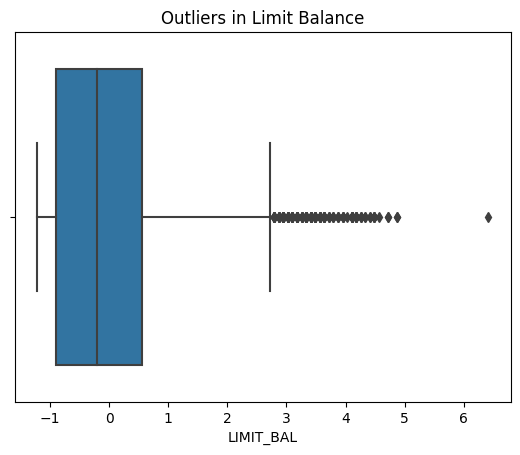

In [7]:
import seaborn as sns
import matplotlib.pyplot as plt

# Boxplot to see outliers
sns.boxplot(x=df['LIMIT_BAL'])
plt.title("Outliers in Limit Balance")
plt.show()

# Use IQR to remove outliers in LIMIT_BAL
Q1 = df['LIMIT_BAL'].quantile(0.25)
Q3 = df['LIMIT_BAL'].quantile(0.75)
IQR = Q3 - Q1

df = df[(df['LIMIT_BAL'] >= Q1 - 1.5*IQR) & (df['LIMIT_BAL'] <= Q3 + 1.5*IQR)]


## Explanation:
### The boxplot visually shows outliers.

### The IQR method statistically removes extreme values:

### Data < Q1 – 1.5×IQR or > Q3 + 1.5×IQR is considered an outlier and removed.

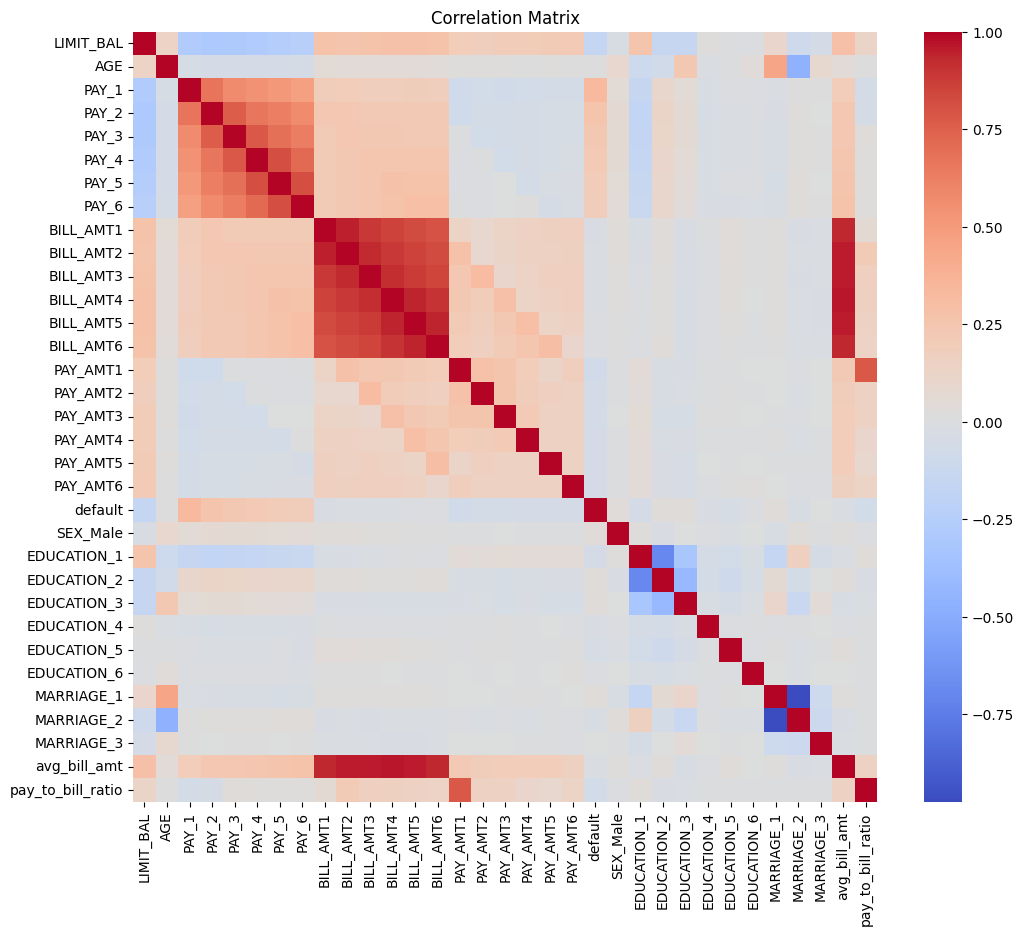

In [8]:
# Correlation Heatmap
corr = df.corr()
plt.figure(figsize=(12, 10))
sns.heatmap(corr, cmap='coolwarm', annot=False)
plt.title("Correlation Matrix")
plt.show()


## Feature Importance using Random Forest

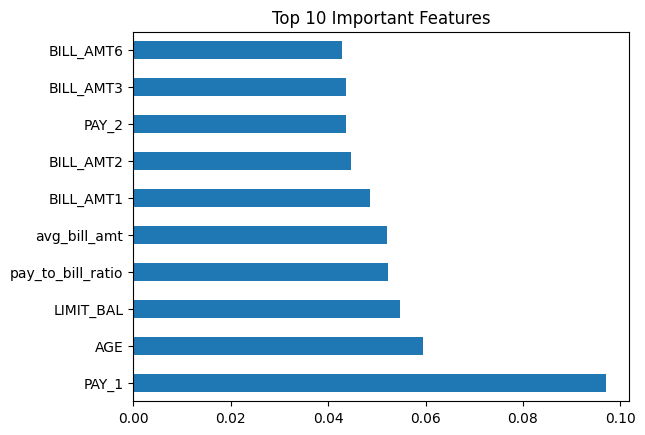

In [12]:
from sklearn.ensemble import RandomForestClassifier

X = df.drop('default', axis=1)
y = df['default']

model = RandomForestClassifier()
model.fit(X, y)

# Get feature importances
importances = pd.Series(model.feature_importances_, index=X.columns)
importances.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Important Features')
plt.show()


## Using Mutual Information

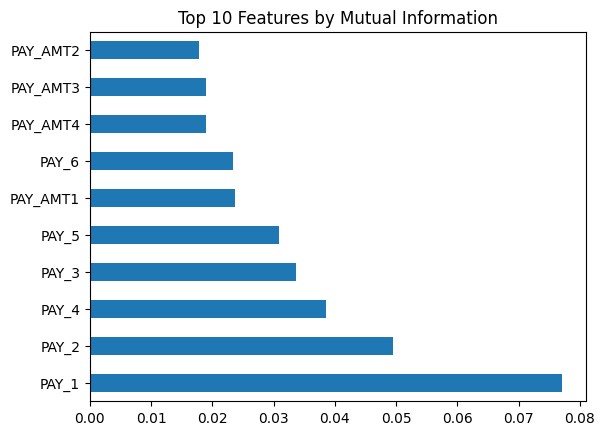

In [13]:
from sklearn.feature_selection import mutual_info_classif

mi = mutual_info_classif(X, y)
mi_series = pd.Series(mi, index=X.columns)
mi_series.sort_values(ascending=False).head(10).plot(kind='barh')
plt.title('Top 10 Features by Mutual Information')
plt.show()


# A short explanation of what changes were made and why


## Data Preprocessing & Feature Engineering – Summary

Here’s a brief explanation of the changes made and why:

1. **Dropped Unnecessary Columns**
   - Removed the `ID` column as it does not provide predictive value for modeling.

2. **Handled Missing Values**
   - Checked for missing values using `.isnull().sum()` – the dataset had no missing values, so no imputation was required.

3. **Removed Duplicates**
   - Verified and confirmed there were no duplicate records using `.duplicated().sum()`.

4. **Encoded Categorical Variables**
   - Mapped numeric values in `SEX`, `EDUCATION`, and `MARRIAGE` columns to meaningful labels (e.g., 1 → Male).
   - Applied one-hot encoding (`pd.get_dummies()`) to convert these categorical columns into numeric binary variables for machine learning compatibility.

5. **Normalized Numerical Features**
   - Used `StandardScaler` to standardize continuous features like `LIMIT_BAL`, `AGE`, `BILL_AMT1-6`, and `PAY_AMT1-6` to improve model performance and training stability.

6. **Feature Engineering**
   - Created new features:
     - `avg_bill_amt`: Average of all bill amounts to summarize monthly spending.
     - `pay_to_bill_ratio`: Ratio of first payment to first bill amount to estimate repayment behavior.

7. **Outlier Detection and Handling**
   - Used boxplots to identify outliers in `LIMIT_BAL`.
   - Applied the IQR method to remove extreme outliers and improve data quality.

8. **Feature Selection (Optional)**
   - Performed feature importance analysis using a Random Forest model to identify the most relevant features for prediction.

These steps helped clean and transform the data to make it suitable for training accurate and interpretable machine learning models.
